In [73]:
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold, rdScaffoldNetwork
from rdkit.Chem import rdFMCS 
from rdkit import DataStructs, Chem
from scipy.spatial.distance import squareform, cdist, pdist
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
import tmap
from faerun import Faerun
from tqdm import tqdm
from glob import glob
import os

from matplotlib.colors import ListedColormap
import matplotlib as mpl

import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import numpy as np
from joblib import load, dump
sns.set(style = 'white', font_scale=2)


from clsar.dataset import LSSNS,HSSMS  # dataset


In [74]:
color = sns.color_palette("jet_r", 100)
custom_cmap = ListedColormap(color[5:-5],name="custom") 

In [75]:
# COc1ncc(C#N)cc1-c1n[nH]cc1NC(=O)c1cnn2cccnc12;CHEMBL3667518: 8.32
# COc1ccc(C#N)cc1-c1nn(Cc2nncn2C)cc1NC(=O)c1cnn2cccnc12;CHEMBL3667517: 8.38
# N#CC1CCN(c2n[nH]cc2NC(=O)c2cnn3cccnc23)CC1;CHEMBL3667527: 6.75
# Cc1nc2cnc3[nH]ccc3c2n1[C@H]1CCCNC1;CHEMBL2159201: 6.82
# O=c1[nH]ccc2c(NC3CCCCC3)ncnc12;CHEMBL2434989: 6.63
# Cc1nc2cnc3[nH]ccc3c2n1C1CCNCC1(F)F;CHEMBL2159204: 8.7


In [76]:
trp1 =  ["CHEMBL3667518", "CHEMBL2159206", "CHEMBL3667527"]
trp2 = ["CHEMBL2159201", "CHEMBL2392482", "CHEMBL2159204"]
triplets = [trp1, trp2] #, trp2

In [77]:
dfg = pd.read_csv('./results_tmap/chemical_space_train.csv', index_col=0).set_index('chembl_id')
s, t = load('./results_tmap/chemical_space_edges_train.jb')

In [78]:
dfg.head()

,x,y,pChEMBL,smiles,node_color,edgecolor,linewidths,node_size,label,alpha,node_shape
chembl_id,,,,,,,,,,,
CHEMBL221959,0.199563,0.240361,9.154902,C[C@@H]1CCN(C(=O)CC#N)C[C@@H]1N(C)c1ncnc2[nH]c...,#0018ff,k,0,200,data,1,o
CHEMBL2152299,0.289971,0.401546,7.920819,C[C@@H]1CCN(Cc2ccccc2)C[C@@H]1n1cnc2cnc3[nH]cc...,#49ffad,k,0,200,data,1,o
CHEMBL2152300,0.195684,0.254125,9.397940,N#CCC(=O)N1CCC[C@@H](n2cnc3cnc4[nH]ccc4c32)C1,#0000ed,k,0,200,data,1,o
CHEMBL2152303,0.270372,0.394460,7.823909,c1ccc(CN2CC[C@@H](n3cnc4cnc5[nH]ccc5c43)C2)cc1,#5dff9a,k,0,200,data,1,o
CHEMBL2152304,0.271975,0.414795,7.207608,c1ccc(CN2CC(n3cnc4cnc5[nH]ccc5c43)C2)cc1,#d4ff23,k,0,200,data,1,o


In [79]:
v = dfg.pChEMBL.values
vmin = v.min()+0.2
vmax = v.max()-0.2 

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet_r)
node_color=[mpl.colors.to_hex(mapper.to_rgba(i)) for i in v]

In [80]:
dfg.node_size = 50
dfg.loc[trp1, 'node_size'] = 80
dfg.loc[trp1, 'label'] = ['A1', 'P1', 'N1']
dfg.loc[trp1, 'linewidths'] = 2
dfg.loc[trp1, 'edgecolor'] = ['b', 'g', 'r']


dfg.loc[trp2, 'node_size'] = 80
dfg.loc[trp2, 'label'] = ['A2', 'P2', 'N2']
dfg.loc[trp2, 'linewidths'] = 2
dfg.loc[trp2, 'edgecolor'] = ['b', 'g', 'r']

In [81]:
dfg1 = dfg[dfg.label == 'data']
dfg2 = dfg[dfg.label != 'data']

dfg.to_csv('./results_tmap/chemical_space_train_new.csv')

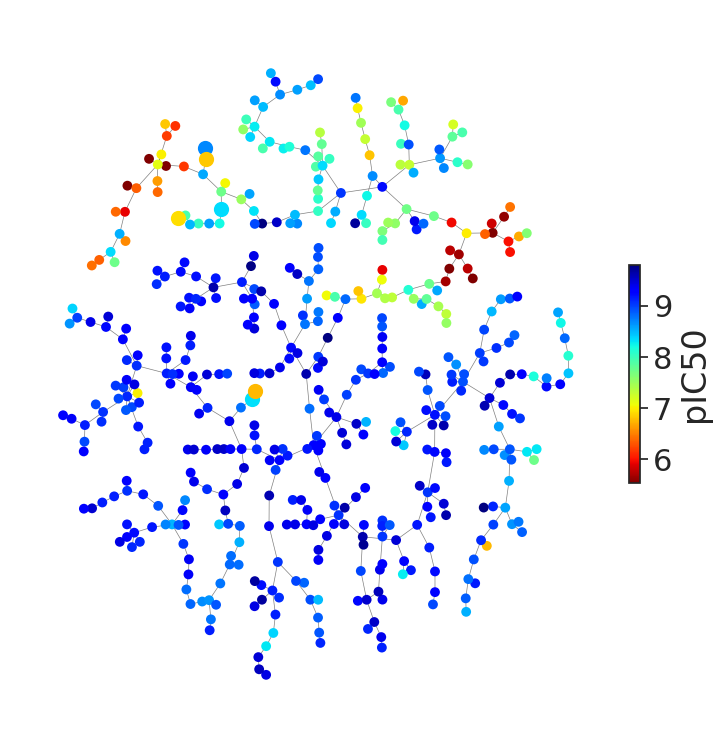

In [87]:
pos = {}
for i, j in dfg.iterrows():
    pos.update({i:j.loc[['x','y']].values})
edgelist = [(dfg.iloc[i].name,dfg.iloc[j].name) for i, j in zip(s,t)]


fig, ax = plt.subplots(figsize=(8,8))

G = nx.Graph()

nx.draw_networkx_nodes(G, pos=pos, ax = ax, 
                       node_size=dfg1.node_size.values, 
                       nodelist=dfg1.index.values, 
                       node_color = dfg1.node_color.values,
                       edgecolors = dfg1.edgecolor.values,
                       linewidths = dfg1.linewidths.values,
                       alpha = dfg1.alpha.values,
                       node_shape = 'o',
                       )

for i in range(len(dfg2)):
    ts = dfg2.iloc[[i]]
    nx.draw_networkx_nodes(G, pos=pos, ax = ax, 
                           node_size = ts.node_size.values, 
                           nodelist=ts.index.values, 
                           node_color = ts.node_color.values,
                           #edgecolors = ts.edgecolor.values,
                           linewidths = ts.linewidths.values,
                           alpha = ts.alpha.values,
                           node_shape = 'o',
                           #label=ts.label.iloc[0]
                           )

nx.draw_networkx_edges(G, pos=pos, 
                       edgelist = edgelist, 
                       ax = ax, width=0.5, edge_color='grey'
                       )

# plt.legend(loc='center')
# ax.legend(scatterpoints = 1, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_facecolor("k")

sm = plt.cm.ScalarMappable(cmap='jet_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax =ax, aspect = 20, shrink = 0.3, pad = 0.01, )
cbar.set_label('pIC50')
cbar.ax.yaxis.set_ticks([6,7,8,9])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.tight_layout()

fig.savefig('./results_tmap/chemical_space.pdf', dpi = 300, bbox_inches='tight')

In [83]:
from rdkit import Chem
from rdkit.Chem import Draw
import cairosvg
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem, DataStructs


Tanimoto similarity (scaffold ECFP4):
A1 vs P1: 0.12
A1 vs N1: 0.60
P1 vs N1: 0.15


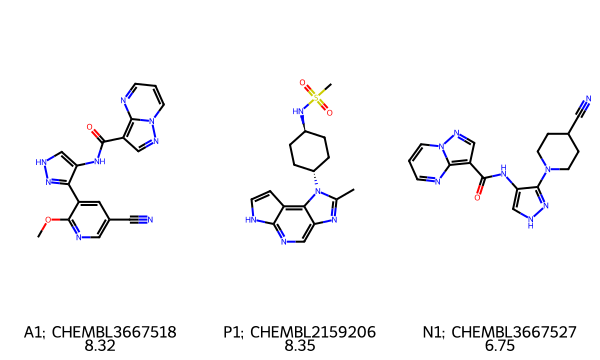

In [84]:
dfd = dfg2.loc[trp1].reset_index()

ms = [Chem.MolFromSmiles(smi) for smi in dfd.smiles]
labels = (dfd.label+'; ' + dfd['chembl_id'] + '\n' + dfd.pChEMBL.round(2).astype(str)).to_list()



# 提取 scaffold 分子
scaffolds = [MurckoScaffold.GetScaffoldForMol(m) for m in ms]
# 生成 scaffold 的指纹（ECFP4）
scaffold_fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048) for m in scaffolds]
# 计算两两 scaffold 相似度
print("Tanimoto similarity (scaffold ECFP4):")
for i in range(len(scaffold_fps)):
    for j in range(i + 1, len(scaffold_fps)):
        sim = DataStructs.TanimotoSimilarity(scaffold_fps[i], scaffold_fps[j])
        print(f"{labels[i].split(';')[0]} vs {labels[j].split(';')[0]}: {sim:.2f}")


mcs_result = rdFMCS.FindMCS(
    ms,
    atomCompare=rdFMCS.AtomCompare.CompareElements,
    bondCompare=rdFMCS.BondCompare.CompareOrder,
    ringMatchesRingOnly=True,
    completeRingsOnly=True,
    matchValences=True,
    timeout=10
)
mcs_smarts = mcs_result.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
mcs_smiles = Chem.MolToSmiles(mcs_mol)

patt = Chem.MolFromSmarts(mcs_smarts)
AllChem.Compute2DCoords(patt)

for m in ms:
    if m.HasSubstructMatch(patt):
        AllChem.GenerateDepictionMatching2DStructure(m, patt)
    else:
        AllChem.Compute2DCoords(m)

img = Draw.MolsToGridImage(ms, useSVG=True, molsPerRow=3, 
                           legends = labels,
                           subImgSize=(200, 360))
cairosvg.svg2pdf(bytestring=img.data.encode(),
                 
                 write_to='./results_tmap/trp1.pdf')
img

Tanimoto similarity (scaffold ECFP4):
A2 vs P2: 0.51
A2 vs N2: 0.74
P2 vs N2: 0.49


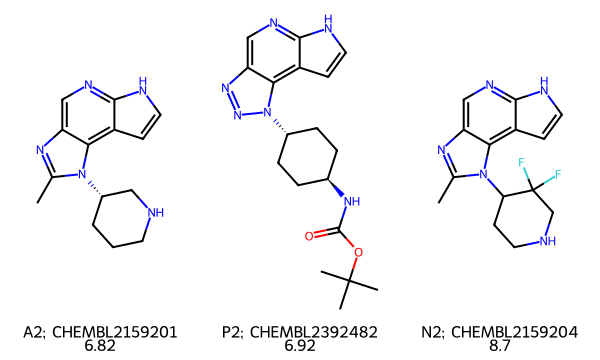

In [85]:
dfd = dfg2.loc[trp2].reset_index()

ms = [Chem.MolFromSmiles(smi) for smi in dfd.smiles]
labels = (dfd.label+'; ' + dfd['chembl_id'] + '\n' + dfd.pChEMBL.round(2).astype(str)).to_list()


# 提取 scaffold 分子
scaffolds = [MurckoScaffold.GetScaffoldForMol(m) for m in ms]
# 生成 scaffold 的指纹（ECFP4）
scaffold_fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048) for m in scaffolds]
# 计算两两 scaffold 相似度
print("Tanimoto similarity (scaffold ECFP4):")
for i in range(len(scaffold_fps)):
    for j in range(i + 1, len(scaffold_fps)):
        sim = DataStructs.TanimotoSimilarity(scaffold_fps[i], scaffold_fps[j])
        print(f"{labels[i].split(';')[0]} vs {labels[j].split(';')[0]}: {sim:.2f}")



mcs_result = rdFMCS.FindMCS(
    ms,
    atomCompare=rdFMCS.AtomCompare.CompareElements,
    bondCompare=rdFMCS.BondCompare.CompareOrder,
    ringMatchesRingOnly=True,
    completeRingsOnly=True,
    matchValences=True,
    timeout=10
)
mcs_smarts = mcs_result.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
mcs_smiles = Chem.MolToSmiles(mcs_mol)


patt = Chem.MolFromSmarts(mcs_smarts)
AllChem.Compute2DCoords(patt)

for m in ms:
    if m.HasSubstructMatch(patt):
        AllChem.GenerateDepictionMatching2DStructure(m, patt)
    else:
        AllChem.Compute2DCoords(m)

img = Draw.MolsToGridImage(ms, useSVG=True, molsPerRow=3, 
                           legends = labels,
                           subImgSize=(200, 360))
cairosvg.svg2pdf(bytestring=img.data.encode(),
                 
                 write_to='./results_tmap/trp2.pdf')
img